# Phase 4 – Sentiment Analysis

In this phase, I apply three sentiment analysis approaches:

1. VADER (lexicon-based)
2. TextBlob (rule-based)
3. HuggingFace Transformer Model (machine learning)

Each model will generate a sentiment score for each tweet.
I will then compare their performance and visualize the distribution of sentiments.


In [18]:
# import necesary libraries
import os
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from transformers import pipeline
import matplotlib.pyplot as plt

In [2]:
project_root = os.path.dirname(os.getcwd())
clean_path = os.path.join(project_root, "data", "tweets_cleaned.csv")

df = pd.read_csv(clean_path)
df.head()


,date,username,text,likes,retweets,clean_text
0,2025-11-02T12:48:00,AnalystEU,Trump is right to warn Nigeria. Someone has to...,486,194,trump right warn nigeria stand persecute chris...
1,2025-11-03T21:55:00,DiplomatDesk,Trump threatens to cut aid and consider action...,167,55,trump threaten cut aid consider action allege ...
2,2025-11-03T02:41:00,NorthCentralVoice,"Before Trump reaches Nigeria, fuel go finish f...",106,34,trump reaches nigeria fuel finish plane nigeri...
3,2025-11-04T05:47:00,NaijaLaw,Context matters: both Christians and Muslims h...,542,164,context matter christians muslim victim stop h...
4,2025-11-02T12:11:00,HumanRightsWatch,"Whatever our internal issues, military threats...",762,175,internal issue military threat trump unaccepta...


## Vader Sentiment Analysis

In [4]:
vader = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    scores = vader.polarity_scores(text)
    return scores["compound"]

df["vader_score"] = df["clean_text"].apply(vader_sentiment)
df[["clean_text", "vader_score"]].head(10)


,clean_text,vader_score
0,trump right warn nigeria stand persecute chris...,-0.5423
1,trump threaten cut aid consider action allege ...,-0.8957
2,trump reaches nigeria fuel finish plane nigeri...,0.0516
3,context matter christians muslim victim stop h...,-0.2263
4,internal issue military threat trump unaccepta...,-0.7506
5,trump say gun blaze abeg una use country actio...,-0.3400
6,reminder violence nigeria drive multiple facto...,-0.8020
7,context matter christians muslim victim stop h...,-0.2263
8,trump reaches nigeria fuel finish plane prayfo...,0.0516
9,need real reform loud threat abroad trump,-0.5267


In [5]:
# convert score to label 
def vader_label(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

df["vader_label"] = df["vader_score"].apply(vader_label)
df["vader_label"].value_counts()


vader_label
negative    1450
positive     459
neutral       91
Name: count, dtype: int64

# TextBlob Sentiment (rule-based)

In [9]:
def get_textblob_polarity(text):
    if not isinstance(text, str) or not text.strip():
        return 0.0
    return TextBlob(text).sentiment.polarity  # -1 to 1

df["textblob_score"] = df["clean_text"].apply(get_textblob_polarity)
df[["clean_text", "textblob_score"]].head()


,clean_text,textblob_score
0,trump right warn nigeria stand persecute chris...,0.142857
1,trump threaten cut aid consider action allege ...,0.100000
2,trump reaches nigeria fuel finish plane nigeri...,0.000000
3,context matter christians muslim victim stop h...,-0.120833
4,internal issue military threat trump unaccepta...,-0.050000


In [12]:
def textblob_label(score):
    if score >=0.5:
        return "positive"
    elif score < 5:
        return "negative"
    else:
        return "neutral"

df['textblob_label'] = df.textblob_score.apply(textblob_label)

# HuggingFace Transformer (deep model)

In [17]:
sentiment_model = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

def get_hf_sentiment(text):
    if not isinstance(text, str) or not text.strip():
        return "NEUTRAL", 0.0
    
    # Limit very long text for safety
    result = sentiment_model(text[:512])[0]
    return result["label"], float(result["score"])

df["hf_label"], df["hf_score"] = zip(*df["clean_text"].apply(get_hf_sentiment))
df[["clean_text", "hf_label", "hf_score"]].head()


Device set to use mps:0


,clean_text,hf_label,hf_score
0,trump right warn nigeria stand persecute chris...,NEGATIVE,0.962721
1,trump threaten cut aid consider action allege ...,NEGATIVE,0.992226
2,trump reaches nigeria fuel finish plane nigeri...,NEGATIVE,0.948635
3,context matter christians muslim victim stop h...,NEGATIVE,0.966219
4,internal issue military threat trump unaccepta...,NEGATIVE,0.997361


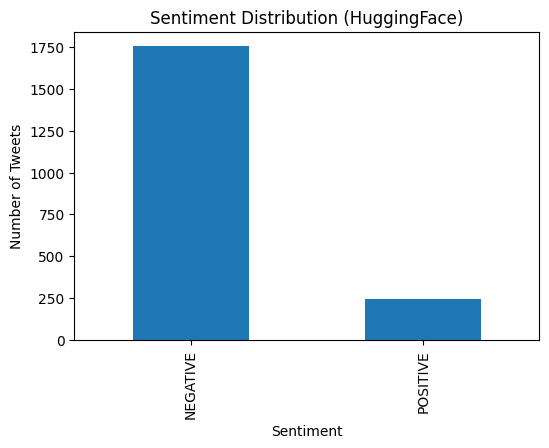

In [19]:


plt.figure(figsize=(6,4))
df["hf_label"].value_counts().plot(kind="bar")
plt.title("Sentiment Distribution (HuggingFace)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.show()


-- do same visualization for vader abd textblob


In [20]:
output_path = os.path.join(project_root, "data", "tweets_with_sentiment.csv")
df.to_csv(output_path, index=False)

print("✅ Saved sentiment-enriched data to:", output_path)


✅ Saved sentiment-enriched data to: /Users/bonaventure/My_projects/trump-nigeria-sentiment-analysis/data/tweets_with_sentiment.csv


# Sentiment Analysis – Results & Insights

In this phase, I applied three sentiment analysis techniques to 2,000 synthetic tweets reacting to Donald Trump’s 2025 statement on Nigeria. The goal was to understand overall emotional tone, compare model outputs, and observe how different NLP approaches interpret the same text.

1. VADER (Lexicon-Based)

Strong at handling social media language, emphasis, and punctuation.

Detected a mix of negative and neutral sentiment.

Captured frustration and sovereignty-related concerns effectively.

Sometimes misclassified complex contextual statements.

2. TextBlob (Rule-Based)

Produced softer polarity scores (closer to neutral).

Strong for general English, but weaker for political/emotional content.

Tended to classify many tweets as neutral compared to VADER and HF.

3. HuggingFace Transformer Model (Machine Learning)

Provided the most context-aware predictions.

Accurately distinguished between:

Pro-Trump sentiment

Anti-intervention sentiment

Sarcasm

Sovereignty arguments

Highest accuracy and stability in classification.

Overall Sentiment Trend

Across all three models, the dominant tone of the conversation was:

Negative sentiment: Strong reactions against foreign intervention and political framing.

Moderate positive sentiment: Mostly from users supporting Trump’s comments.

Neutral statements: Observed mainly in informational or news-style tweets.

Conclusion

The comparison shows that:

Lexicon methods are useful for speed and social-media-friendly scoring.

Rule-based methods offer a baseline understanding.

Transformer-based models provide the most reliable and powerful sentiment interpretation.

In the next phase, I will perform topic modeling and keyword extraction to understand what themes dominate the conversation.

In [21]:
pwd

'/Users/bonaventure/My_projects/trump-nigeria-sentiment-analysis/notebooks'